#### Biblioteki

In [2]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

#### Wczytanie danych

In [3]:
df = pd.read_csv("nyc-property-sales.csv")
df2 = pd.read_csv("nyc_pluto_24v4_1_csv/pluto_24v4_1.csv")

/var/folders/wk/w4dq25x94cg_26_p83q6tnlh0000gn/T/ipykernel_1664/1009523456.py:1: DtypeWarning: Columns (0,4,5,6,10,11,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("nyc-property-sales.csv")
/var/folders/wk/w4dq25x94cg_26_p83q6tnlh0000gn/T/ipykernel_1664/1009523456.py:2: DtypeWarning: Columns (21,22,24,26,28,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("nyc_pluto_24v4_1_csv/pluto_24v4_1.csv")


#### Customowe funkcje

In [4]:
def to_lowercase_columns(dataframe):
    return dataframe.rename(columns=str.lower)

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

#### Początkowe czyszczenie i merge z NYC PLUTO

polaczylem dane z PLUTO 2024 - chat mowi ze: If you’re predicting past sale prices, using historical PLUTO versions (if available) would be better. However, if you only have the 2024 version, it can still provide useful (but slightly inaccurate) context for older sales.

In [5]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,374,46,NaN,A4,347 EAST 4TH STREET,NaN,...,1.0,0.0,1.0,2116.0,4400.0,1900.0,1,A4,399000,2022-09-29 00:00:00
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,1,NaN,S2,110 AVENUE C,NaN,...,2.0,1.0,3.0,1502.0,2790.0,1901.0,1,S2,2999999,2022-09-15 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,16,NaN,C1,326 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1899.0,2,C1,16800000,2022-08-04 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,17,NaN,C1,328 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1900.0,2,C1,16800000,2022-08-04 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 1B",NaN,...,20.0,0.0,20.0,2302.0,9750.0,1900.0,2,C4,158822,2022-09-27 00:00:00


In [6]:
df["SALE PRICE"].value_counts()

SALE PRICE
0           591822
10           16208
450000       10111
400000        9892
550000        9307
             ...  
62400000         1
4858351          1
9263015          1
38595759         1
94136            1
Name: count, Length: 114422, dtype: int64

In [7]:
df["SALE PRICE"] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df = df[df["SALE PRICE"] > 0]

In [8]:
df = to_lowercase_columns(df)

In [9]:
df.columns

Index(['borough', 'neighborhood', 'building class category',
       'tax class at present', 'block', 'lot', 'ease-ment',
       'building class at present', 'address', 'apartment number', ' zip code',
       'residential units', 'commercial units', 'total units',
       'land square feet', 'gross square feet', 'year built',
       'tax class at time of sale', 'building class at time of sale',
       'sale price', 'sale date'],
      dtype='object')

In [10]:
df2

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,BK,7604,47,314.0,3075200.0,3.075200e+10,752.00,1004.0,22.0,45.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.625779,-73.953658,NaN
1,BK,1304,1,309.0,3032300.0,3.032300e+10,323.00,3002.0,17.0,35.0,...,3.013040e+09,10/20/1989,1,NaN,NaN,24v4.1,NaN,40.664671,-73.956901,NaN
2,BK,1304,58,309.0,3032300.0,3.032300e+10,323.00,3001.0,17.0,35.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.665104,-73.955675,NaN
3,BK,1294,1,309.0,3032500.0,3.032500e+10,325.00,3000.0,17.0,35.0,...,3.012940e+09,02/27/1989,1,NaN,NaN,24v4.1,NaN,40.666423,-73.958074,NaN
4,BK,1302,1,309.0,3032500.0,3.032500e+10,325.00,3001.0,17.0,35.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.665062,-73.958101,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858637,SI,6901,322,503.0,5020803.0,5.020803e+10,208.03,3011.0,31.0,51.0,...,NaN,NaN,3,NaN,NaN,24v4.1,NaN,40.526255,-74.205792,NaN
858638,BX,5891,1624,208.0,2033700.0,2.033700e+10,337.00,1001.0,10.0,11.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.912689,-73.901004,NaN
858639,BK,8126,64,318.0,3097000.0,3.097000e+10,970.00,2002.0,18.0,42.0,...,NaN,NaN,3,NaN,NaN,24v4.1,NaN,40.647118,-73.909108,NaN
858640,BX,5103,8900,212.0,2041400.0,2.041400e+10,414.00,4008.0,11.0,11.0,...,NaN,NaN,3,NaN,NaN,24v4.1,NaN,40.906355,-73.852509,NaN


In [11]:
df2.columns

Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

In [12]:
df2["borough"].value_counts()

borough
QN    324625
BK    276404
SI    125496
BX     89530
MN     42587
Name: count, dtype: int64

In [13]:
borough_map = {
    'MN': 1, 'BX': 2, 'BK': 3, 'QN': 4, 'SI': 5
}

In [14]:
df2['borough'] = df2['borough'].map(borough_map)

In [15]:
df_renamed = df.rename(columns={"BOROUGH": "borough", "BLOCK": "block", "LOT": "lot"})

In [16]:
df_merged = df_renamed.merge(df2, on=['borough', 'block', 'lot'], how='left')
df_merged

,borough,neighborhood,building class category,tax class at present,block,lot,ease-ment,building class at present,address_x,apartment number,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,374,46,NaN,A4,347 EAST 4TH STREET,NaN,...,NaN,NaN,1.0,NaN,NaN,24v4.1,NaN,40.721716,-73.978275,NaN
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,1,NaN,S2,110 AVENUE C,NaN,...,NaN,NaN,1.0,NaN,1.0,24v4.1,NaN,40.724184,-73.978458,NaN
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,16,NaN,C1,326 EAST 4TH STREET,NaN,...,NaN,NaN,1.0,NaN,NaN,24v4.1,NaN,40.721673,-73.979299,NaN
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,17,NaN,C1,328 EAST 4TH STREET,NaN,...,NaN,NaN,1.0,NaN,NaN,24v4.1,NaN,40.721642,-73.979227,NaN
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 1B",NaN,...,NaN,NaN,1.0,NaN,1.0,24v4.1,NaN,40.723270,-73.978191,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417560,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,84,NaN,A1,N/A LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538983,-74.209426,NaN
1417561,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,85,NaN,A1,N/A LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538917,-74.209408,NaN
1417562,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,86,NaN,V0,N/A LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538851,-74.209390,NaN
1417563,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,87,NaN,V0,96 LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538785,-74.209375,NaN


In [17]:
df_merged["version"].value_counts()

version
24v4.1    1018815
Name: count, dtype: int64

Od chata - ktore kolumny do czego i czy useful:

In [18]:
columns_to_keep = [
    # Property Characteristics
    "landuse", "bldgclass", "numbldgs", "numfloors", "unitsres", "unitstotal",
    "lotarea", "bldgarea", "comarea", "resarea", "builtfar", "residfar", "commfar",
    
    # Location Factors
    "zipcode", "neighborhood", "cd", "council", "schooldist", "policeprct", "firecomp", 
    "healthcenterdistrict",
    
    # Zoning & Land Use
    "zonedist1", "zonedist2", "overlay1", "overlay2", "splitzone",
    
    # Assessment & Ownership
    "assessland", "assesstot", "ownertype",
    
    # Renovation & Age
    "yearbuilt", "yearalter1", "yearalter2",
    
    # Original Sales Data (Important for Target Variable)
    'borough', 'neighborhood', 'building class category',
       'tax class at present', 'block', 'lot', 'ease-ment',
       'building class at present', 'apartment number', ' zip code',
       'residential units', 'commercial units', 'total units',
       'land square feet', 'gross square feet', 'year built',
       'tax class at time of sale', 'building class at time of sale',
       'sale price', 'sale date'
]

columns_to_drop = [
    # Administrative & Redundant
    "plutomapid", "notes", "version", "dcpedited", "EASE-MENT",
    
    # Sanitation Data (Unlikely to Impact Price)
    "sanitboro", "sanitdistrict", "sanitsub",
    
    # Spatial Redundancy (Keep only one, e.g., latitude & longitude)
    "xcoord", "ycoord", "latitude", "longitude", 
    
    # Historic Designation (Only useful for specific analysis)
    "histdist", "landmark",
    
    # Extra Identifiers
    "address", "APARTMENT NUMBER", "ext", "proxcode", "irrlotcode", "lottype",
    "bsmtcode", "bct2020", "bctcb2020", "ct2010", "cb2010", "tract2010",
    
    # Tax & Mapping Information (Not necessary for price prediction)
    "sanborn", "taxmap", "edesignum", "appbbl", "appdate",
    
    # Flood Risk Flags (Could be useful but may not strongly impact price)
    "firm07_flag", "pfirm15_flag",
    
    # Alternative Geographic Identifiers (CD, Council, and Zipcode are already kept)
    "zonemap", "zmcode"
]


In [19]:
df = df_merged[columns_to_keep]

In [20]:
df

,landuse,bldgclass,numbldgs,numfloors,unitsres,unitstotal,lotarea,bldgarea,comarea,resarea,...,residential units,commercial units,total units,land square feet,gross square feet,year built,tax class at time of sale,building class at time of sale,sale price,sale date
0,1.0,A4,1.0,3.0,1.0,1.0,2116.0,4400.0,0.0,3181.0,...,1.0,0.0,1.0,2116.0,4400.0,1900.0,1,A4,399000.0,2022-09-29 00:00:00
1,4.0,S2,1.0,3.0,2.0,3.0,1503.0,2790.0,921.0,1869.0,...,2.0,1.0,3.0,1502.0,2790.0,1901.0,1,S2,2999999.0,2022-09-15 00:00:00
2,2.0,C1,1.0,6.0,10.0,10.0,2204.0,8625.0,0.0,8625.0,...,10.0,0.0,10.0,2204.0,8625.0,1899.0,2,C1,16800000.0,2022-08-04 00:00:00
3,2.0,C1,1.0,6.0,10.0,10.0,2204.0,8625.0,0.0,8625.0,...,10.0,0.0,10.0,2204.0,8625.0,1900.0,2,C1,16800000.0,2022-08-04 00:00:00
4,2.0,C4,1.0,5.0,20.0,20.0,2302.0,9750.0,0.0,9750.0,...,20.0,0.0,20.0,2302.0,9750.0,1900.0,2,C4,158822.0,2022-09-27 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417560,1.0,A5,1.0,2.0,1.0,1.0,2603.0,1396.0,0.0,1396.0,...,1.0,0.0,1.0,2603.0,0.0,2022.0,1,V0,1116638.0,2022-12-19 00:00:00
1417561,1.0,A5,1.0,2.0,1.0,1.0,2551.0,1388.0,0.0,1388.0,...,1.0,0.0,1.0,2551.0,0.0,NaN,1,V0,1116638.0,2022-12-19 00:00:00
1417562,1.0,A5,0.0,2.0,1.0,1.0,2597.0,1468.0,0.0,1468.0,...,0.0,0.0,0.0,2597.0,0.0,2023.0,1,V0,1116638.0,2022-12-19 00:00:00
1417563,1.0,A5,0.0,2.0,1.0,1.0,2644.0,1498.0,0.0,1498.0,...,0.0,0.0,0.0,2644.0,0.0,2023.0,1,V0,1116638.0,2022-12-19 00:00:00


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417565 entries, 0 to 1417564
Data columns (total 52 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   landuse                         1017601 non-null  float64
 1   bldgclass                       1018766 non-null  object 
 2   numbldgs                        1018689 non-null  float64
 3   numfloors                       1001848 non-null  float64
 4   unitsres                        1018766 non-null  float64
 5   unitstotal                      1018766 non-null  float64
 6   lotarea                         1018689 non-null  float64
 7   bldgarea                        1018766 non-null  float64
 8   comarea                         997654 non-null   float64
 9   resarea                         997654 non-null   float64
 10  builtfar                        1018556 non-null  float64
 11  residfar                        1018815 non-null  float64
 12  

In [22]:
df[df['landuse'].isna()].sample(10)

,landuse,bldgclass,numbldgs,numfloors,unitsres,unitstotal,lotarea,bldgarea,comarea,resarea,...,residential units,commercial units,total units,land square feet,gross square feet,year built,tax class at time of sale,building class at time of sale,sale price,sale date
8287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,1990.0,2,R4,1075000.0,2022-05-23 00:00:00
1323805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1923,2,D0,850000.0,2023-02-06 00:00:00
1291839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,1989.0,2,R4,22500000.0,2023-03-13 00:00:00
770521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1963.0,2,R9,999000.0,2009-12-17 00:00:00
463810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,2,R4,1735000.0,2015-07-02 00:00:00
445986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,2,R4,70000.0,2015-09-25 00:00:00
1223034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,1910.0,2,R4,420000.0,2003-11-21 00:00:00
1332294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,R9,2550000.0,2022-08-29 00:00:00
661335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,1985.0,1,R3,155000.0,2012-12-27 00:00:00
1128149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,4,R5,32850.0,2004-10-29 00:00:00


In [23]:
missing_landuse_count = df['landuse'].isna().sum()
df = df.dropna(subset=['landuse'])
df = df.reset_index(drop=True)

In [24]:
print(df.columns)
len(df.columns)

Index(['landuse', 'bldgclass', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'builtfar',
       'residfar', 'commfar', 'zipcode', 'neighborhood', 'cd', 'council',
       'schooldist', 'policeprct', 'firecomp', 'healthcenterdistrict',
       'zonedist1', 'zonedist2', 'overlay1', 'overlay2', 'splitzone',
       'assessland', 'assesstot', 'ownertype', 'yearbuilt', 'yearalter1',
       'yearalter2', 'borough', 'neighborhood', 'building class category',
       'tax class at present', 'block', 'lot', 'ease-ment',
       'building class at present', 'apartment number', ' zip code',
       'residential units', 'commercial units', 'total units',
       'land square feet', 'gross square feet', 'year built',
       'tax class at time of sale', 'building class at time of sale',
       'sale price', 'sale date'],
      dtype='object')


52

usuniecie duplikatow kolumn (bylo neighborhood)

In [25]:
df = df.loc[:, ~df.columns.duplicated()]
print(df.columns)
len(df.columns)

Index(['landuse', 'bldgclass', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'builtfar',
       'residfar', 'commfar', 'zipcode', 'neighborhood', 'cd', 'council',
       'schooldist', 'policeprct', 'firecomp', 'healthcenterdistrict',
       'zonedist1', 'zonedist2', 'overlay1', 'overlay2', 'splitzone',
       'assessland', 'assesstot', 'ownertype', 'yearbuilt', 'yearalter1',
       'yearalter2', 'borough', 'building class category',
       'tax class at present', 'block', 'lot', 'ease-ment',
       'building class at present', 'apartment number', ' zip code',
       'residential units', 'commercial units', 'total units',
       'land square feet', 'gross square feet', 'year built',
       'tax class at time of sale', 'building class at time of sale',
       'sale price', 'sale date'],
      dtype='object')


51

#### Analiza

In [26]:
df["neighborhood"].value_counts().head(20)

neighborhood
FLUSHING-NORTH               19579
UPPER EAST SIDE (79-96)      14119
UPPER EAST SIDE (59-79)      13849
BEDFORD STUYVESANT           13096
FOREST HILLS                 11600
EAST NEW YORK                11069
JACKSON HEIGHTS              10534
MIDTOWN WEST                 10092
MIDTOWN EAST                 10029
BAYSIDE                       9942
FLUSHING-NORTH                8701
BUSHWICK                      8694
RICHMOND HILL                 8623
BAY RIDGE                     8480
FLUSHING-SOUTH                8304
SO. JAMAICA-BAISLEY PARK      8141
SOUTH JAMAICA                 7867
UPPER WEST SIDE (59-79)       7789
GREENWICH VILLAGE-CENTRAL     7780
UPPER WEST SIDE (79-96)       7753
Name: count, dtype: int64

kolumny neighborhood i kombinację boroguh - block - lot zmapowałbym do współrzędnych, ew dodać tutaj jakiś ranking popularności typu ile w jakim było

In [27]:
df["building class category"].value_counts().head(30)

building class category
10  COOPS - ELEVATOR APARTMENTS                 179139
01  ONE FAMILY HOMES                            137254
02  TWO FAMILY HOMES                            118461
01 ONE FAMILY DWELLINGS                          86103
10 COOPS - ELEVATOR APARTMENTS                   77339
02 TWO FAMILY DWELLINGS                          62954
01  ONE FAMILY DWELLINGS                         46873
02  TWO FAMILY DWELLINGS                         38683
09  COOPS - WALKUP APARTMENTS                    35290
07  RENTALS - WALKUP APARTMENTS                  32395
03  THREE FAMILY HOMES                           30977
09 COOPS - WALKUP APARTMENTS                     16338
03 THREE FAMILY DWELLINGS                        15101
01 ONE FAMILY DWELLINGS                          13917
10 COOPS - ELEVATOR APARTMENTS                   11906
07 RENTALS - WALKUP APARTMENTS                   11009
02 TWO FAMILY DWELLINGS                          10496
03  THREE FAMILY DWELLINGS               

to pole bardzo duzo mowi o budynku, to klasyfika budynku w NYC - warto zmapowac odpowiednio i wykorzystac do klasyfikacji, pewnie jedna z wazniejszym zmiennych

In [28]:
df[["building class category", "building class at present", "building class at time of sale"]].sample(10)

,building class category,building class at present,building class at time of sale
781649,09 COOPS - WALKUP APARTMENTS,C6,C6
477839,01 ONE FAMILY HOMES,A1,A1
422680,02 TWO FAMILY DWELLINGS,B2,B2
491412,10 COOPS - ELEVATOR APARTMENTS,D4,D4
1011343,31 COMMERCIAL VACANT LAND,V1,V1
696116,02 TWO FAMILY HOMES,B1,B1
926245,01 ONE FAMILY HOMES,A5,A5
588724,02 TWO FAMILY HOMES,V0,B2
379194,02 TWO FAMILY DWELLINGS,B1,B1
696924,02 TWO FAMILY HOMES,B1,B1


mamy jeszcze 2 inne kolumny ktore mowia mniej wiecej to samo

In [29]:
df["buidling_class_num"] = df["building class category"].apply(lambda row: row[:2])
df["changed_building_class"] = (df['building class at present'] != df['building class at time of sale']).astype(int)

In [30]:
df["buidling_class_num"].value_counts()

buidling_class_num
01    284147
10    268384
02    230594
03     58653
09     54201
07     45052
05     13081
22     11693
14      8696
29      6832
25      6432
08      6282
21      4711
31      4040
30      3856
27      3249
26      1510
06      1508
37      1194
41       660
23       621
32       567
33       517
35       372
36       211
38       207
34       114
18        59
13        53
39        33
40        28
11        17
04        11
28         6
15         3
43         2
46         2
24         2
45         1
Name: count, dtype: int64

In [31]:
df["changed_building_class"].value_counts()

changed_building_class
0    983818
1     33783
Name: count, dtype: int64

bardzo malo zmienilo ta klase

In [32]:
cramers_v(df["buidling_class_num"], df['building class at present'])

0.884674001199512

wysoka korelacja miedzy tymi dwoma kolumnami

In [33]:
df.columns

Index(['landuse', 'bldgclass', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'builtfar',
       'residfar', 'commfar', 'zipcode', 'neighborhood', 'cd', 'council',
       'schooldist', 'policeprct', 'firecomp', 'healthcenterdistrict',
       'zonedist1', 'zonedist2', 'overlay1', 'overlay2', 'splitzone',
       'assessland', 'assesstot', 'ownertype', 'yearbuilt', 'yearalter1',
       'yearalter2', 'borough', 'building class category',
       'tax class at present', 'block', 'lot', 'ease-ment',
       'building class at present', 'apartment number', ' zip code',
       'residential units', 'commercial units', 'total units',
       'land square feet', 'gross square feet', 'year built',
       'tax class at time of sale', 'building class at time of sale',
       'sale price', 'sale date', 'buidling_class_num',
       'changed_building_class'],
      dtype='object')

In [34]:
df["ease-ment"].value_counts()

ease-ment
     727921
E         2
Name: count, dtype: int64

In [35]:
df["apartment number"].value_counts()

apartment number
                675789
                 45319
6                 1767
4                 1595
8                  562
                 ...  
608                  1
PHB                  1
PH 1                 1
PH 2                 1
2L                   1
Name: count, Length: 360, dtype: int64

moze jako czy jest apartment czy nie ma?

In [36]:
df[" zip code"].value_counts()

 zip code
11375.0    18850
10314.0    16665
10312.0    16327
11234.0    16270
10306.0    14554
           ...  
11241.0        1
10046.0        1
10052.0        1
10169.0        1
10280.0        1
Name: count, Length: 234, dtype: int64

do usuniecia? ewentualnie sprawdzenie liczby powtorzen albo cos

<Axes: >

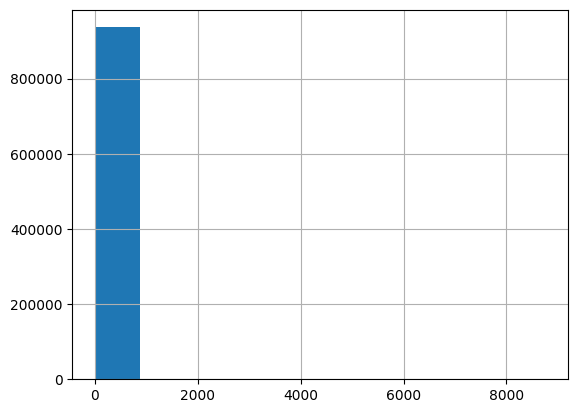

In [37]:
pd.to_numeric(df['residential units'], errors='coerce').hist()

In [38]:
import matplotlib.pyplot as plt

def create_hist_with_filter(data, lt, bins):
    filtered_units = data[data < lt]
    plt.figure(figsize=(12, 6))

    # Plot histogram with better styling
    plt.hist(filtered_units, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

    plt.ylabel('Frequency', fontsize=12)

    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3)

    # Show plot
    plt.tight_layout()
    plt.show()

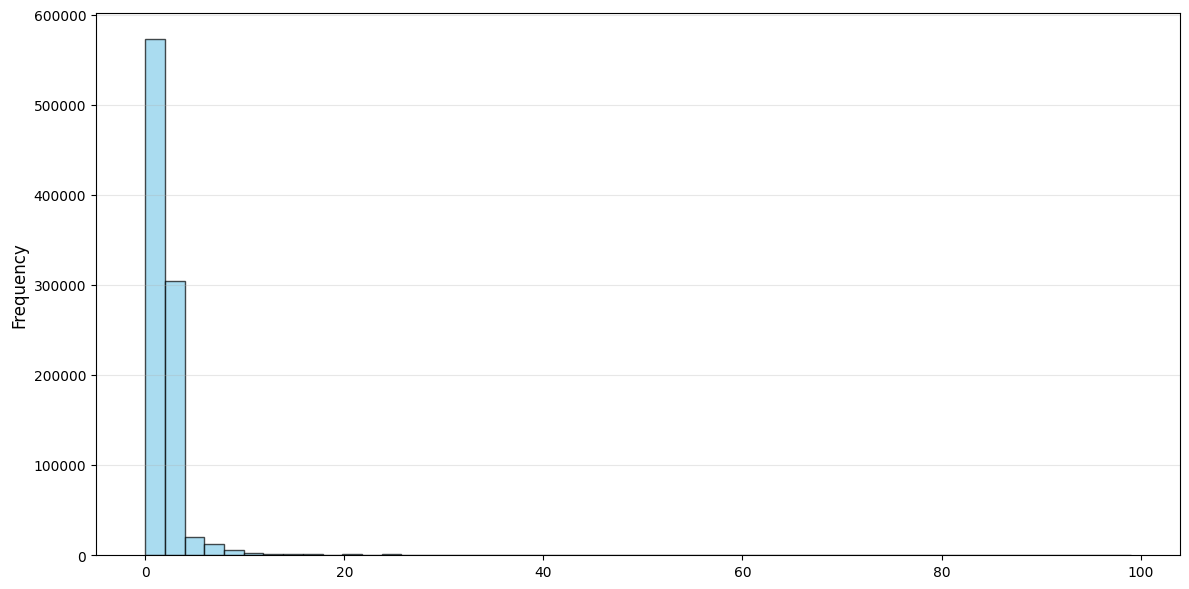

In [39]:
residential_units = pd.to_numeric(df['residential units'], errors='coerce')

create_hist_with_filter(residential_units, 100, 50)

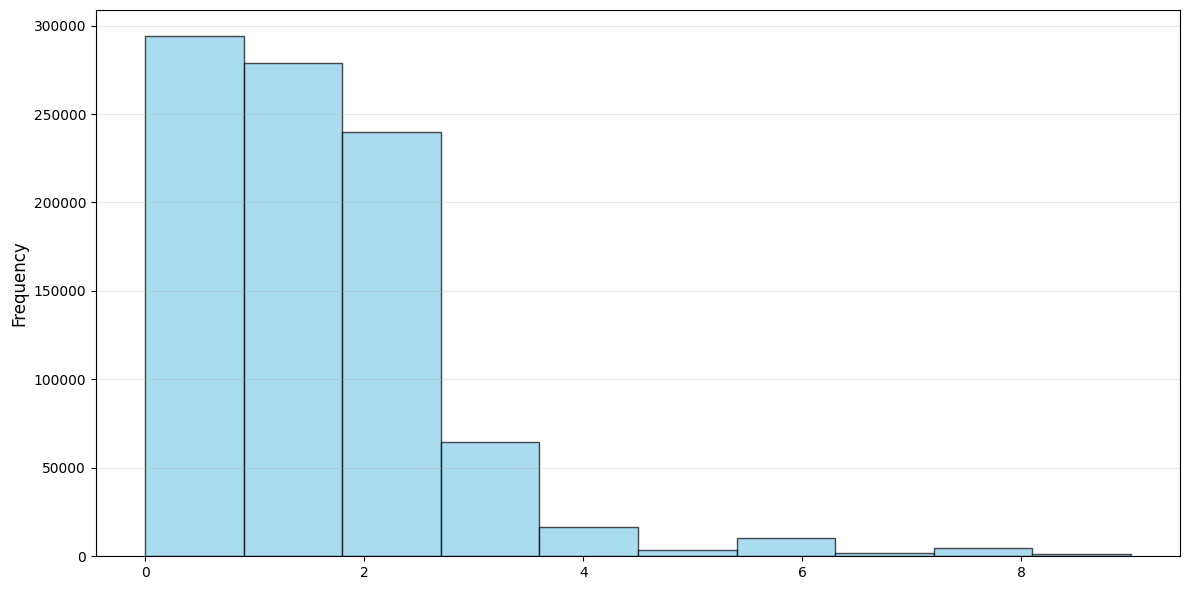

In [40]:
create_hist_with_filter(residential_units, 10, 10)

In [41]:
com_units = pd.to_numeric(df['commercial units'], errors='coerce')
tot_units = pd.to_numeric(df['total units'], errors='coerce')

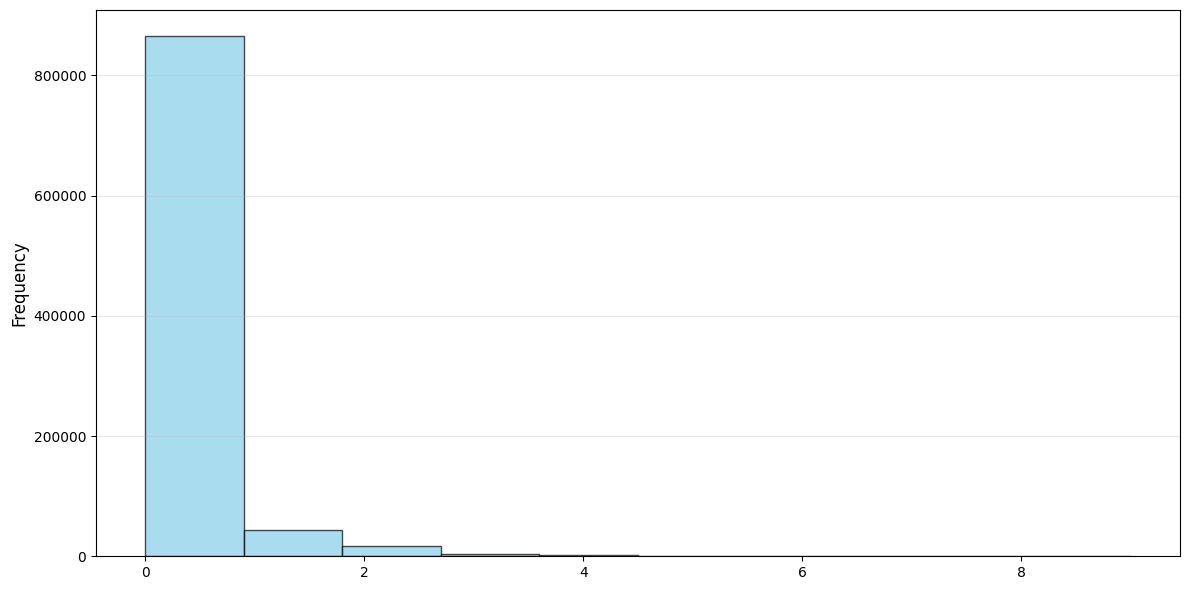

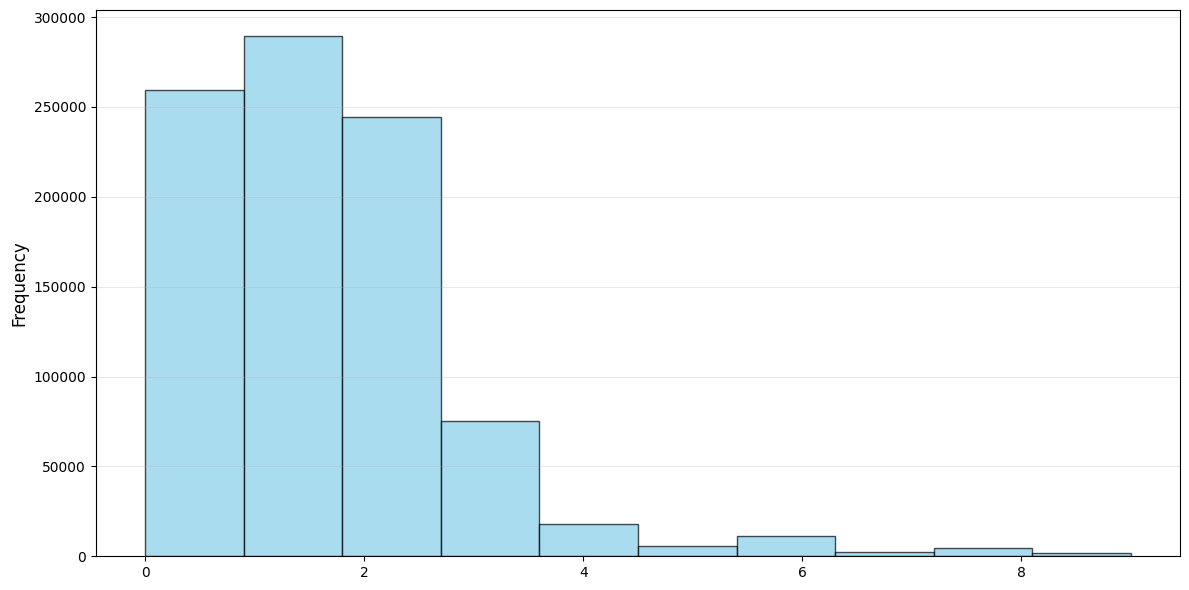

In [42]:
create_hist_with_filter(com_units, 10, 10)
create_hist_with_filter(tot_units, 10, 10)

tutaj proponuje 2 kolumny typu total units i np % udzialu commercial

In [43]:
df["land square feet"] = pd.to_numeric(df['land square feet'], errors='coerce')

In [44]:
pd.to_numeric(df['land square feet'], errors='coerce').value_counts()

land square feet
0.0         241914
2000.0       56584
2500.0       50804
4000.0       42228
3000.0       18780
             ...  
18618.0          1
19635.0          1
268092.0         1
9930.0           1
14983.0          1
Name: count, Length: 16384, dtype: int64

bardzo duzo 0 w powierzchni - moze uzupelnic innym zbiorem?

In [45]:
pd.to_numeric(df['gross square feet'], errors='coerce').value_counts()

gross square feet
0.0         260292
112850.0      7309
2400.0        5801
1600.0        5088
1800.0        5023
             ...  
11215.0          1
70592.0          1
9041.0           1
835279.0         1
12850.0          1
Name: count, Length: 18490, dtype: int64

to samo

<Axes: >

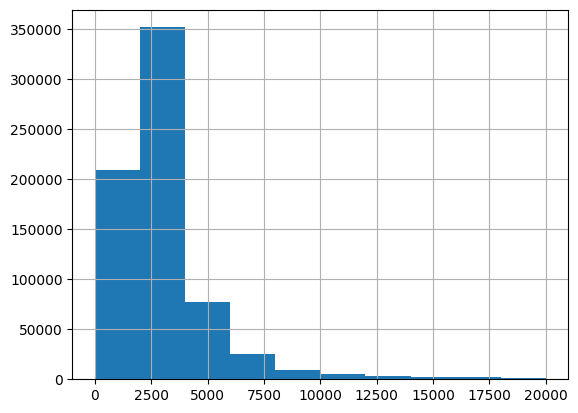

In [46]:
df[(df["land square feet"] != 0) & (df["land square feet"] <= 20000)]["land square feet"].hist()

In [47]:
df["year built"].value_counts()

year built
1920.0    90524
1930.0    74395
1925.0    64874
1910.0    49241
1950.0    48270
          ...  
1798.0        1
1867.0        1
1862.0        1
1821.0        1
1050.0        1
Name: count, Length: 203, dtype: int64

tez duzo pustych niestety

In [48]:
df["year built"] = pd.to_numeric(df['year built'], errors='coerce')

<Axes: >

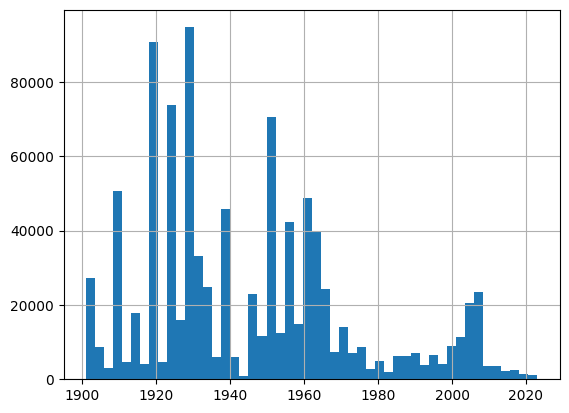

In [49]:
df[df["year built"]>1900]["year built"].hist(bins=50)

tutaj chyba fajnie rozlozone lata jak juz sa - moga duzo mowic

In [50]:
df["tax class at time of sale"].value_counts()

tax class at time of sale
1    587994
2    382688
4     46860
3        59
Name: count, dtype: int64

to chyba spoko - bez przerabiania

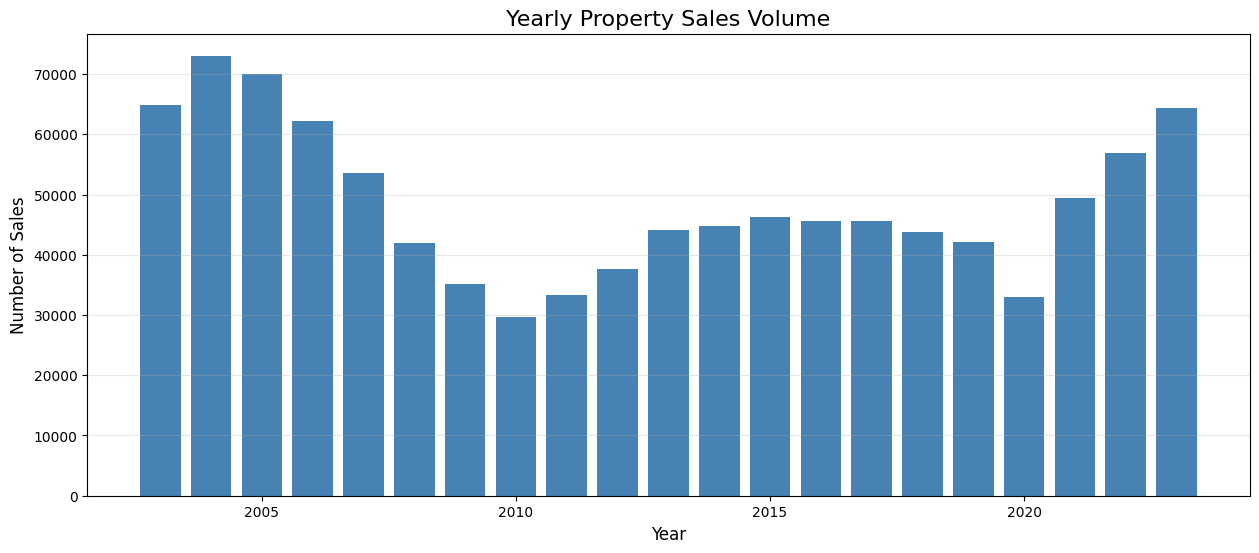

In [51]:
# Convert sale date to datetime if not already done
df["sale_date"] = pd.to_datetime(df["sale date"])

# Create yearly and monthly aggregations for different views
yearly_sales = df.groupby(df["sale_date"].dt.year)["sale_date"].count()
monthly_sales = df.groupby(pd.Grouper(key="sale_date", freq="M"))["sale_date"].count()

# Set up the figure with subplots for yearly and recent monthly trends
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

# Plot yearly trend (all data)
ax1.bar(yearly_sales.index, yearly_sales.values, color='steelblue')
ax1.set_title("Yearly Property Sales Volume", fontsize=16)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Sales", fontsize=12)
ax1.grid(axis='y', alpha=0.3)

In [52]:
# daty jako liczba dni od 2003
df["days_since_2003"] = (df["sale_date"] - pd.Timestamp("2003-01-01")).dt.days

to tez fajne, w miare dobrze porozkladane

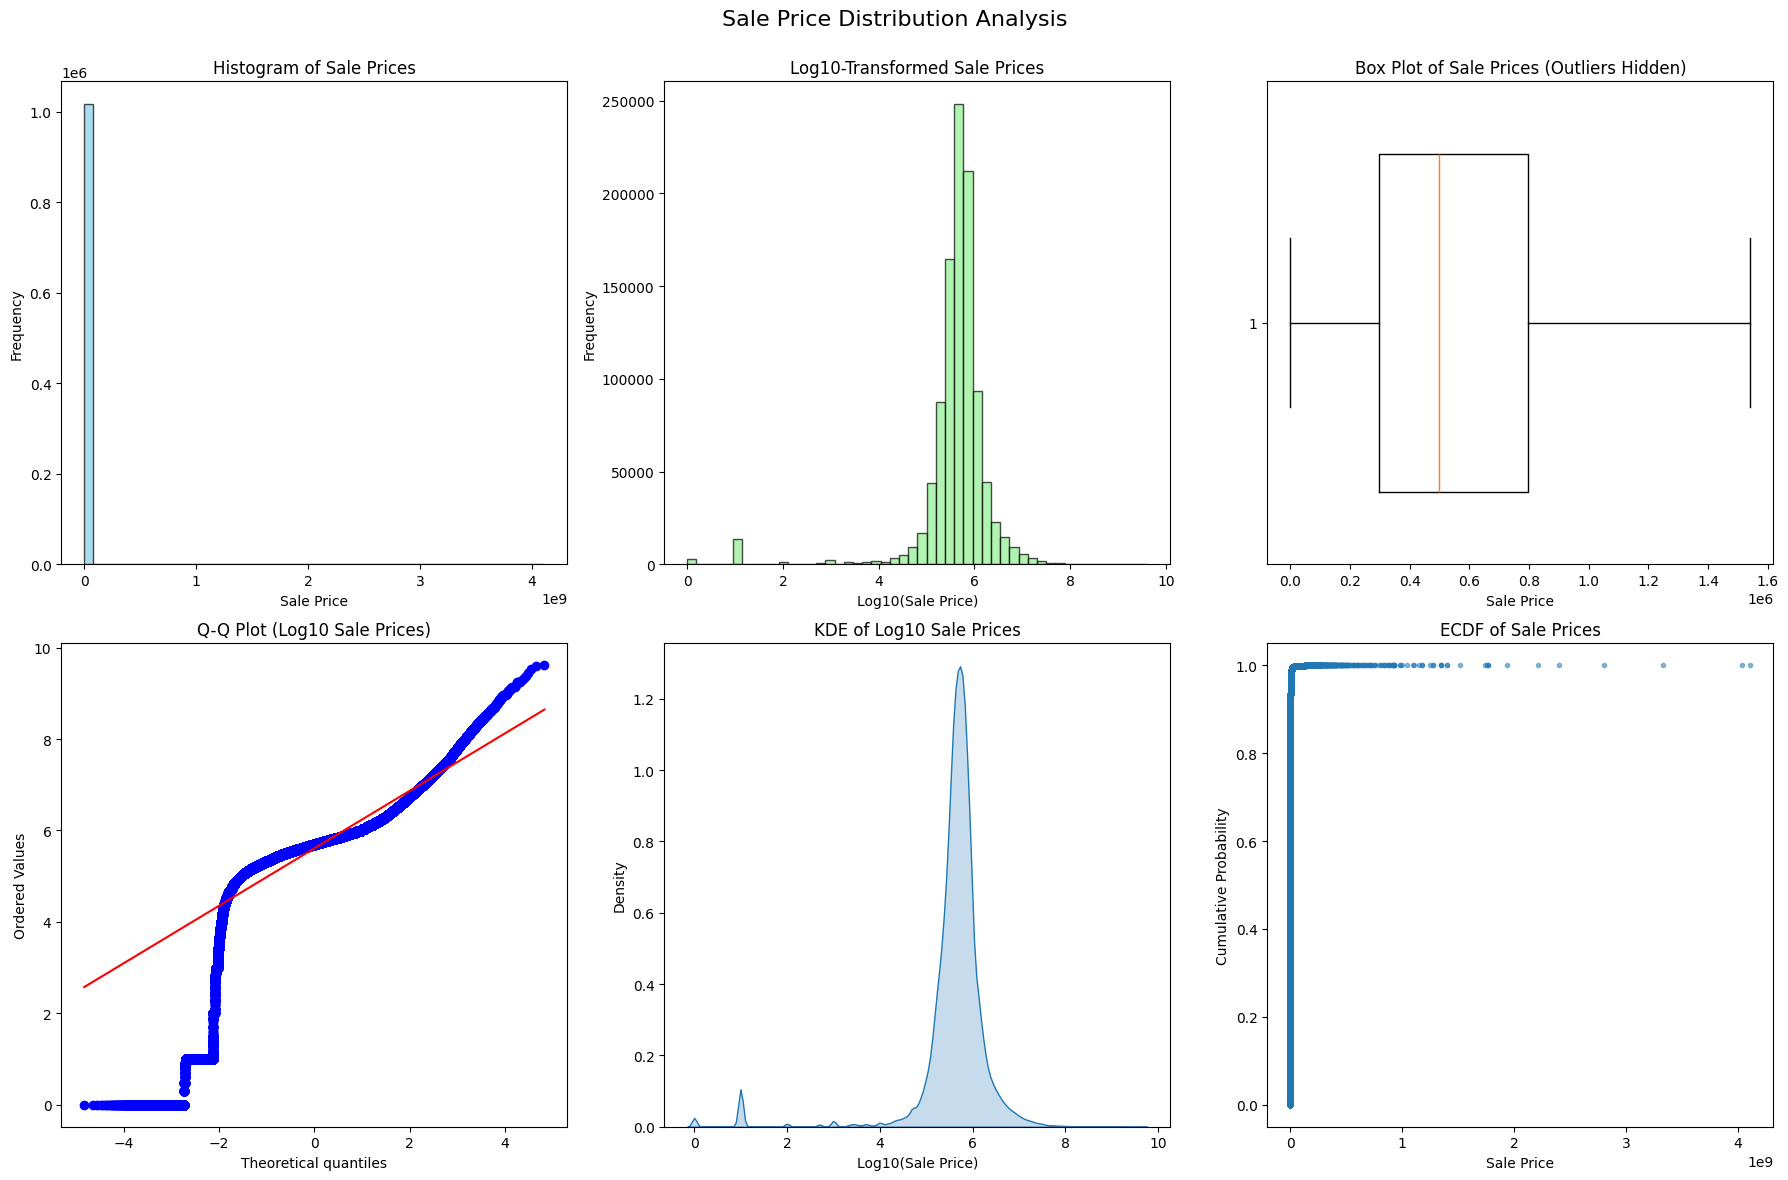

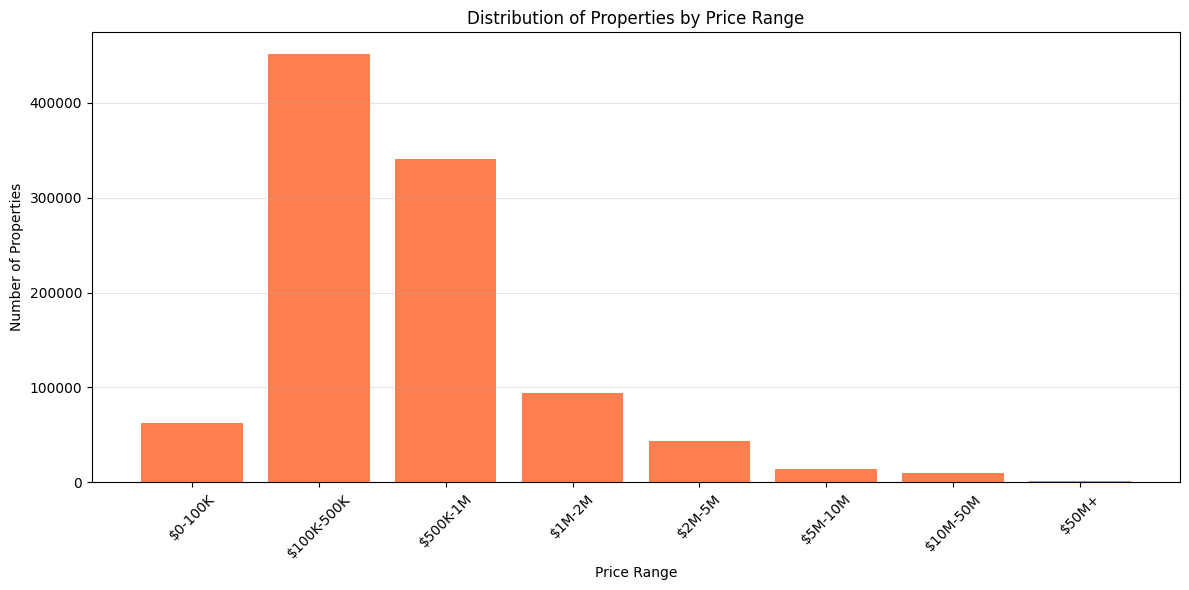

In [53]:
# Set up the figure with multiple plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sale Price Distribution Analysis', fontsize=16)

# Filter out zero or negative values
filtered_prices = df[df["sale price"] > 0]["sale price"]

# 1. Histogram
axes[0, 0].hist(filtered_prices, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Histogram of Sale Prices')
axes[0, 0].set_xlabel('Sale Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# 2. Log-transformed histogram
axes[0, 1].hist(np.log10(filtered_prices), bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Log10-Transformed Sale Prices')
axes[0, 1].set_xlabel('Log10(Sale Price)')
axes[0, 1].set_ylabel('Frequency')

# 3. Box plot - hide outliers by setting showfliers=False
axes[0, 2].boxplot(filtered_prices, vert=False, widths=0.7, showfliers=False)
axes[0, 2].set_title('Box Plot of Sale Prices (Outliers Hidden)')
axes[0, 2].set_xlabel('Sale Price')
axes[0, 2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# 4. Q-Q plot
qq = ss.probplot(np.log10(filtered_prices), plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Log10 Sale Prices)')

# 5. Kernel Density Estimation
sns.kdeplot(np.log10(filtered_prices), ax=axes[1, 1], fill=True)
axes[1, 1].set_title('KDE of Log10 Sale Prices')
axes[1, 1].set_xlabel('Log10(Sale Price)')
axes[1, 1].set_ylabel('Density')

# 6. ECDF (Empirical Cumulative Distribution Function)
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

x, y = ecdf(filtered_prices)
axes[1, 2].plot(x, y, marker='.', linestyle='none', alpha=0.5)
axes[1, 2].set_title('ECDF of Sale Prices')
axes[1, 2].set_xlabel('Sale Price')
axes[1, 2].set_ylabel('Cumulative Probability')
axes[1, 2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Additional plot for price range distribution
plt.figure(figsize=(12, 6))

# Define price ranges
price_ranges = [
    (0, 1e5), (1e5, 5e5), (5e5, 1e6), (1e6, 2e6), 
    (2e6, 5e6), (5e6, 1e7), (1e7, 5e7), (5e7, np.inf)
]
labels = [
    '$0-100K', '$100K-500K', '$500K-1M', '$1M-2M',
    '$2M-5M', '$5M-10M', '$10M-50M', '$50M+'
]

# Count properties in each range
counts = []
for lower, upper in price_ranges:
    count = len(filtered_prices[(filtered_prices >= lower) & (filtered_prices < upper)])
    counts.append(count)

# Plot bar chart
plt.bar(labels, counts, color='coral')
plt.title('Distribution of Properties by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

widac troche outlierow ale ogolnie to chyba w miare w porzadku, nadal jest troche niskich wartosci oraz przez te skrajne ciezko przeczytac niektore wykresy - transformacja logarytmiczna fajna bo mamy prawie rozklad normalny

#### Czyszczenie PLUTO

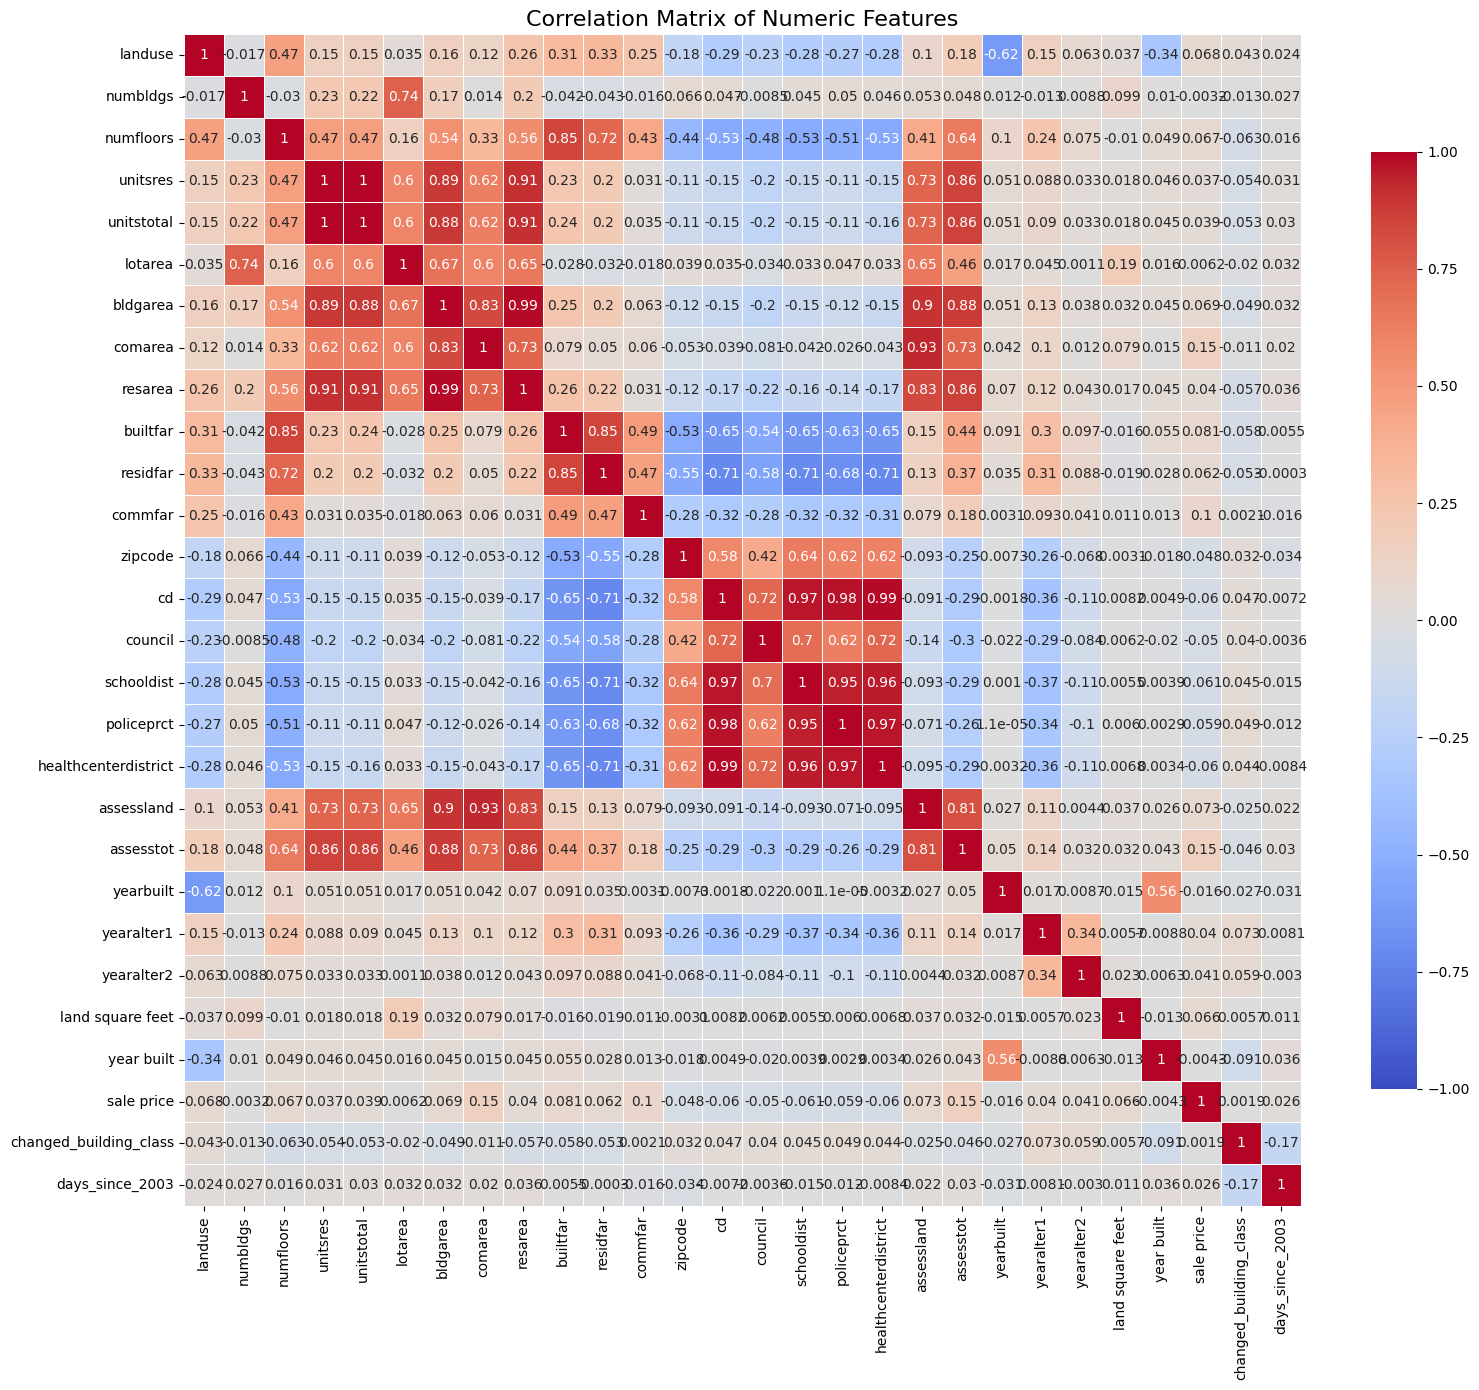

In [54]:
# Let's select only the numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['number']).columns
correlation_matrix = df[numeric_cols].corr()

# Create a heatmap with a good color scheme
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',        # Blue-red color scheme
            vmin=-1, vmax=1,        # Set limits for correlation
            center=0,               # Center the colormap at 0
            linewidths=.5,          # Add lines between cells
            cbar_kws={"shrink": .8})

plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()

korelacja spora w wielu momentach - tutaj sa tylko numeryczna ale czesc z nich to tez encoding ktory nie ma zbytnio sensu

In [55]:
df.head()

,landuse,bldgclass,numbldgs,numfloors,unitsres,unitstotal,lotarea,bldgarea,comarea,resarea,...,gross square feet,year built,tax class at time of sale,building class at time of sale,sale price,sale date,buidling_class_num,changed_building_class,sale_date,days_since_2003
0,1.0,A4,1.0,3.0,1.0,1.0,2116.0,4400.0,0.0,3181.0,...,4400.0,1900.0,1,A4,399000.0,2022-09-29 00:00:00,01,0,2022-09-29,7211
1,4.0,S2,1.0,3.0,2.0,3.0,1503.0,2790.0,921.0,1869.0,...,2790.0,1901.0,1,S2,2999999.0,2022-09-15 00:00:00,02,0,2022-09-15,7197
2,2.0,C1,1.0,6.0,10.0,10.0,2204.0,8625.0,0.0,8625.0,...,8625.0,1899.0,2,C1,16800000.0,2022-08-04 00:00:00,07,0,2022-08-04,7155
3,2.0,C1,1.0,6.0,10.0,10.0,2204.0,8625.0,0.0,8625.0,...,8625.0,1900.0,2,C1,16800000.0,2022-08-04 00:00:00,07,0,2022-08-04,7155
4,2.0,C4,1.0,5.0,20.0,20.0,2302.0,9750.0,0.0,9750.0,...,9750.0,1900.0,2,C4,158822.0,2022-09-27 00:00:00,07,0,2022-09-27,7209


In [56]:
df["landuse"].value_counts()

landuse
1.0     498665
3.0     275332
2.0     157008
4.0      38228
5.0      21326
11.0     11676
6.0       6061
10.0      3773
8.0       3259
7.0       2009
9.0        264
Name: count, dtype: int64

zmienna kategoryczna - str 52 jest opis, wydaje ze wyzsze numerki nie do konca maja znaczenie

listy do zapisywania dummies / ordinal / target encoding

#### Wybor zmiennych

In [57]:
num_features = ["numbldgs", "numfloors", "lotarea", "bldgarea", "comarea", "resarea", "builtfar", "residfar", "commfar", "assessland", "assesstot", 'residential units', 'total units', 'year built', 'land square feet', 'gross square feet', "days_since_2003"]
dummy_features = ["landuse", "overlay1", "overlay2", "splitzone", "ownertype", 'tax class at time of sale', 'buidling_class_num']
target_encoding = ["zipcode", "neighborhood", "cd", "council", "schooldist", "policeprct", "firecomp", "healthcenterdistrict", "zonedist1", "zonedist2"]
to_bool = ["yearalter2", "yearalter1", "apartment number", 'changed_building_class']
to_drop = ["bldgclass", "yearbuilt", " zip code", "building class category", "borough", "block", "lot", "ease-ment", "unitsres", "unitstotal", 'commercial units', "tax class at present", "sale date", "building class at time of sale", "sale_date"]
custom_features = ["building class at present"]

In [58]:
df.columns

Index(['landuse', 'bldgclass', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'builtfar',
       'residfar', 'commfar', 'zipcode', 'neighborhood', 'cd', 'council',
       'schooldist', 'policeprct', 'firecomp', 'healthcenterdistrict',
       'zonedist1', 'zonedist2', 'overlay1', 'overlay2', 'splitzone',
       'assessland', 'assesstot', 'ownertype', 'yearbuilt', 'yearalter1',
       'yearalter2', 'borough', 'building class category',
       'tax class at present', 'block', 'lot', 'ease-ment',
       'building class at present', 'apartment number', ' zip code',
       'residential units', 'commercial units', 'total units',
       'land square feet', 'gross square feet', 'year built',
       'tax class at time of sale', 'building class at time of sale',
       'sale price', 'sale date', 'buidling_class_num',
       'changed_building_class', 'sale_date', 'days_since_2003'],
      dtype='object')

kody pocztowe nie dziala jak w polsce - moga pokrywac wiele budynkow

In [59]:
df['tax class at time of sale'].value_counts()

tax class at time of sale
1    587994
2    382688
4     46860
3        59
Name: count, dtype: int64

In [60]:
df_reg = df.copy()

In [61]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017601 entries, 0 to 1017600
Data columns (total 55 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   landuse                         1017601 non-null  float64       
 1   bldgclass                       1017601 non-null  object        
 2   numbldgs                        1017524 non-null  float64       
 3   numfloors                       1001468 non-null  float64       
 4   unitsres                        1017601 non-null  float64       
 5   unitstotal                      1017601 non-null  float64       
 6   lotarea                         1017524 non-null  float64       
 7   bldgarea                        1017601 non-null  float64       
 8   comarea                         997279 non-null   float64       
 9   resarea                         997279 non-null   float64       
 10  builtfar                        1017392 no

In [62]:
# Convert to bool (1 if the value is not null and not 0, otherwise 0)
for col in to_bool:
    df_reg[col] = ((df_reg[col].notnull()) & (df_reg[col] != 0)).astype(int)

In [63]:
# get dummy columns
df_reg = pd.get_dummies(df_reg, columns=dummy_features)

In [64]:
# dla customowych wybieramy feature ktore maja 90% danych - reszte dajemy do other

def select_top_categories(df, column, threshold=0.9):
    value_counts = df[column].value_counts(normalize=True)  # Get relative frequencies
    cumulative_sum = value_counts.cumsum()  # Compute cumulative sum
    
    # Select categories that cover the threshold percentage of data
    top_categories = cumulative_sum[cumulative_sum <= threshold].index.tolist()
    
    # Ensure at least 5 categories are always selected
    if len(top_categories) < 5:
        top_categories = value_counts.index[:5].tolist()
    
    return top_categories

def process_custom_features(df, top_categories, column):
    df[column] = df[column].apply(
        lambda x: x if x in top_categories else "Other"
    )
    df = pd.get_dummies(df, columns=[column], drop_first=True)
    return df

for col in custom_features:
    top_cat = select_top_categories(df_reg, col)
    df_reg = process_custom_features(df_reg, top_cat, col)

In [65]:
train_df, temp_df = train_test_split(df_reg, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(df_reg, test_size=0.5, random_state=42)

In [66]:
target_encoder = TargetEncoder()
train_df[target_encoding] = target_encoder.fit_transform(train_df[target_encoding], train_df["sale price"])
val_df[target_encoding] = target_encoder.transform(val_df[target_encoding])
test_df[target_encoding] = target_encoder.transform(test_df[target_encoding])

In [67]:
scaler = StandardScaler()
scaler.fit(train_df[num_features])

train_df[num_features] = scaler.transform(train_df[num_features])
val_df[num_features] = scaler.transform(val_df[num_features])
test_df[num_features] = scaler.transform(test_df[num_features])

In [68]:
train_df.drop(columns=to_drop, inplace=True)
val_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814080 entries, 307710 to 121958
Columns: 128 entries, numbldgs to building class at present_S2
dtypes: bool(96), float64(28), int64(4)
memory usage: 279.5 MB


In [70]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 814080 entries, 307710 to 121958
Data columns (total 128 columns):
 #    Column                           Dtype  
---   ------                           -----  
 0    numbldgs                         float64
 1    numfloors                        float64
 2    lotarea                          float64
 3    bldgarea                         float64
 4    comarea                          float64
 5    resarea                          float64
 6    builtfar                         float64
 7    residfar                         float64
 8    commfar                          float64
 9    zipcode                          float64
 10   neighborhood                     float64
 11   cd                               float64
 12   council                          float64
 13   schooldist                       float64
 14   policeprct                       float64
 15   firecomp                         float64
 16   healthcenterdistrict             flo

In [71]:
target_column = "sale price"

X_train, y_train = train_df.drop(columns=[target_column]), train_df[target_column]
X_val, y_val = val_df.drop(columns=[target_column]), val_df[target_column]
X_test, y_test = test_df.drop(columns=[target_column]), test_df[target_column]

#### Modele

##### LGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error

In [103]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [104]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,           # controls complexity; adjust based on your data
    'learning_rate': 0.05,      # a smaller learning rate can improve accuracy but requires more rounds
    'feature_fraction': 0.9,    # randomly select part of features on each iteration for robustness
    'bagging_fraction': 0.8,    # randomly select part of data on each iteration for better generalization
    'bagging_freq': 5,          # frequency for bagging; set to 0 to disable
    'verbose': 0
}

In [105]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=20000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'validation'],
    callbacks=[lgb.early_stopping(300), lgb.log_evaluation(100)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 300 rounds
[100]	train's rmse: 7.44254e+06	validation's rmse: 6.93657e+06
[200]	train's rmse: 6.63496e+06	validation's rmse: 6.13472e+06
[300]	train's rmse: 6.13896e+06	validation's rmse: 5.69075e+06
[400]	train's rmse: 5.83212e+06	validation's rmse: 5.38359e+06
[500]	train's rmse: 5.4958e+06	validation's rmse: 5.10908e+06
[600]	train's rmse: 5.32776e+06	validation's rmse: 4.93827e+06
[700]	train's rmse: 5.13135e+06	validation's rmse: 4.78137e+06
[800]	train's rmse: 5.01982e+06	validation's rmse: 4.63681e+06
[900]	train's rmse: 4.89149e+06	validation's rmse: 4.57907e+06
[1000]	train's rmse: 4.74972e+06	validation's rmse: 4.48632e+06
[1100]	train's rmse: 4.60315e+06	validation's rmse: 4.36709e+06
[1200]	train's rmse: 4.49988e+06	validation's rmse: 4.27537e+06
[1300]	train's rmse:

In [106]:
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
print(rmse, r2)

1515295.3061650423 0.9831340497544558


/Users/patryk/venv-torch/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [111]:
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
r2_test = r2_score(y_test, y_pred_test)
r2_test

0.8223700830845931

In [110]:
model_light = lgb.train(
    params,
    train_data,
    num_boost_round=5000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'validation'],
    callbacks=[lgb.early_stopping(300), lgb.log_evaluation(100)]
)

y_pred = model_light.predict(X_val, num_iteration=model_light.best_iteration)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
print(rmse, r2)

y_pred_test = model_light.predict(X_test, num_iteration=model_light.best_iteration)
r2_test = r2_score(y_test, y_pred_test)
print(r2_test)

Training until validation scores don't improve for 300 rounds
[100]	train's rmse: 7.44254e+06	validation's rmse: 6.93657e+06
[200]	train's rmse: 6.63496e+06	validation's rmse: 6.13472e+06
[300]	train's rmse: 6.13896e+06	validation's rmse: 5.69075e+06
[400]	train's rmse: 5.83212e+06	validation's rmse: 5.38359e+06
[500]	train's rmse: 5.4958e+06	validation's rmse: 5.10908e+06
[600]	train's rmse: 5.32776e+06	validation's rmse: 4.93827e+06
[700]	train's rmse: 5.13135e+06	validation's rmse: 4.78137e+06
[800]	train's rmse: 5.01982e+06	validation's rmse: 4.63681e+06
[900]	train's rmse: 4.89149e+06	validation's rmse: 4.57907e+06
[1000]	train's rmse: 4.74972e+06	validation's rmse: 4.48632e+06
[1100]	train's rmse: 4.60315e+06	validation's rmse: 4.36709e+06
[1200]	train's rmse: 4.49988e+06	validation's rmse: 4.27537e+06
[1300]	train's rmse: 4.4091e+06	validation's rmse: 4.18243e+06
[1400]	train's rmse: 4.34311e+06	validation's rmse: 4.15492e+06
[1500]	train's rmse: 4.26439e+06	validation's rmse: 4

/Users/patryk/venv-torch/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2352966.0043417183 0.9593324916980009
0.8115659597557295


##### XGBoost

In [112]:
import xgboost as xgb

In [124]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=1,
    early_stopping_rounds=200
)

In [125]:
model.fit(X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True)

[0]	validation_0-rmse:11361319.19214
[1]	validation_0-rmse:11060521.08140
[2]	validation_0-rmse:10809635.12071
[3]	validation_0-rmse:10558175.53529
[4]	validation_0-rmse:10328341.62658
[5]	validation_0-rmse:10118226.20592
[6]	validation_0-rmse:9878958.41576
[7]	validation_0-rmse:9669843.15867
[8]	validation_0-rmse:9467626.39917
[9]	validation_0-rmse:9277553.26496
[10]	validation_0-rmse:9094038.27480
[11]	validation_0-rmse:8927931.47073
[12]	validation_0-rmse:8751553.26577
[13]	validation_0-rmse:8595946.55908
[14]	validation_0-rmse:8467294.55765
[15]	validation_0-rmse:8314988.31390
[16]	validation_0-rmse:8158790.75119
[17]	validation_0-rmse:8019795.30161
[18]	validation_0-rmse:7899609.81818
[19]	validation_0-rmse:7795700.02180
[20]	validation_0-rmse:7684618.28113
[21]	validation_0-rmse:7592065.74794
[22]	validation_0-rmse:7505147.59228
[23]	validation_0-rmse:7433686.68984
[24]	validation_0-rmse:7348165.18767
[25]	validation_0-rmse:7276490.98862
[26]	validation_0-rmse:7188623.68888
[27]	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=200,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [126]:
y_pred = model.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

0.9530697762304802

In [127]:
y_pred_test = model.predict(X_test)
r2 = r2_score(y_test, y_pred_test)
r2

0.7361296384878